# Working with dask data frames. Reading Fiscal Data from a sqlite db to a dask dataframe. Computing, visualizing and groupby with dask dataframes. Using dask.distributed locally.

This post includes code from [Scalable-Data-Analysis-in-Python-with-Dask](https://github.com/PacktPublishing/-Scalable-Data-Analysis-in-Python-with-Dask/tree/master/Section%202) and [coiled-examples](https://github.com/coiled/coiled-examples).

In [ ]:
import numpy as np
import dask.array as da
import pandas as pd
import sqlalchemy as db
from sqlalchemy import create_engine
import sqlite3
import pandas as pd

In [3]:
engine = db.create_engine('sqlite:///fiscal_data.db')
connection = engine.connect()
metadata = db.MetaData()

In [4]:
engine.execute("SELECT * FROM fiscal_data LIMIT 1").fetchall()

[(1996, 'East China', 'Anhui', '2093.3', 50661, 631930, 147002)]

In [5]:
sql = """
SELECT year
, region
, province
, gdp
, fdi
, it
, specific
FROM fiscal_data
"""

cnxn = connection

In [6]:
df = pd.read_sql(sql, cnxn)

In [7]:
df

,year,region,province,gdp,fdi,it,specific
0,1996,East China,Anhui,2093.3,50661,631930,147002.0
1,1997,East China,Anhui,2347.32,43443,657860,151981.0
2,1998,East China,Anhui,2542.96,27673,889463,174930.0
3,1999,East China,Anhui,2712.34,26131,1227364,285324.0
4,2000,East China,Anhui,2902.09,31847,1499110,195580.0
...,...,...,...,...,...,...,...
355,2003,East China,Zhejiang,9705.02,498055,2261631,391292.0
356,2004,East China,Zhejiang,11648.7,668128,3162299,656175.0
357,2005,East China,Zhejiang,13417.68,772000,2370200,656175.0
358,2006,East China,Zhejiang,15718.47,888935,2553268,1017303.0


In [8]:
df.columns

Index(['year', 'region', 'province', 'gdp', 'fdi', 'it', 'specific'], dtype='object')

In [10]:
from dask import dataframe as dd 

In [12]:
ddf = dd.from_pandas(df, npartitions=5)

In [13]:
print(ddf)

Dask DataFrame Structure:
                year  region province     gdp    fdi     it specific
npartitions=5                                                       
0              int64  object   object  object  int64  int64  float64
72               ...     ...      ...     ...    ...    ...      ...
...              ...     ...      ...     ...    ...    ...      ...
288              ...     ...      ...     ...    ...    ...      ...
359              ...     ...      ...     ...    ...    ...      ...
Dask Name: from_pandas, 5 tasks


In [15]:
ddf.npartitions

5

In [16]:
ddf.npartitions

5

In [17]:
len(ddf)

360

In [18]:
from dask.distributed import Client

client = Client(processes=False, threads_per_worker=2,
                n_workers=3, memory_limit='4GB')
client

Client Scheduler: inproc://192.168.1.71/12451/1 Dashboard: http://localhost:8787/status,Cluster Workers: 3 Cores: 6 Memory: 12.00 GB


In [19]:
ddf.describe().compute()

,year,fdi,it,specific
count,360.000000,3.600000e+02,3.600000e+02,3.560000e+02
mean,2001.500000,1.961394e+05,2.165819e+06,5.834707e+05
std,3.456857,3.030440e+05,1.769294e+06,6.540553e+05
min,1996.000000,2.000000e+00,1.478970e+05,8.964000e+03
25%,1998.750000,3.309900e+04,1.077466e+06,2.237530e+05
50%,2001.500000,1.411025e+05,2.020634e+06,4.243700e+05
75%,2004.250000,4.065125e+05,3.375492e+06,1.011846e+06
max,2007.000000,1.743140e+06,1.053331e+07,3.937966e+06


In [20]:
ddf.head()

,year,region,province,gdp,fdi,it,specific
0,1996,East China,Anhui,2093.3,50661,631930,147002.0
1,1997,East China,Anhui,2347.32,43443,657860,151981.0
2,1998,East China,Anhui,2542.96,27673,889463,174930.0
3,1999,East China,Anhui,2712.34,26131,1227364,285324.0
4,2000,East China,Anhui,2902.09,31847,1499110,195580.0


In [21]:
groupby_yr = ddf.groupby('year').count()

In [22]:
groupby_yr.compute()

,region,province,gdp,fdi,it,specific
year,,,,,,
1996,30,30,30,30,30,29
1997,30,30,30,30,30,28
1998,30,30,30,30,30,30
1999,30,30,30,30,30,30
2000,30,30,30,30,30,29
2001,30,30,30,30,30,30
2002,30,30,30,30,30,30
2003,30,30,30,30,30,30
2004,30,30,30,30,30,30


In [23]:
group_region = ddf.groupby('region')['gdp'].sum()

In [24]:
group_region.compute()

region
East China             2093.32347.322542.962712.342902.093246.713519....
North China            1789.22077.092377.182678.823161.663707.964315....
Northwest China        722.52793.57887.67956.321052.881125.371232.031...
South Central China    6834.977774.538530.889250.6810741.2512039.2513...
Southwest China        1315.121509.751602.381663.21791.01976.862232.8...
Northeast China        2370.52667.52774.42866.33151.43390.13637.24057...
Name: gdp, dtype: object

In [26]:
ddf.nlargest(5, 'fdi').compute()

,year,region,province,gdp,fdi,it,specific
179,2007,East China,Jiangsu,21742.05,1743140,3557071,1188989.0
71,2007,South Central China,Guangdong,31777.01,1712603,4947824,859482.0
70,2006,South Central China,Guangdong,26587.76,1451065,4559252,1897575.0
178,2006,East China,Jiangsu,18598.69,1318339,2926542,1388043.0
69,2005,South Central China,Guangdong,22557.37,1236400,4327217,1491588.0


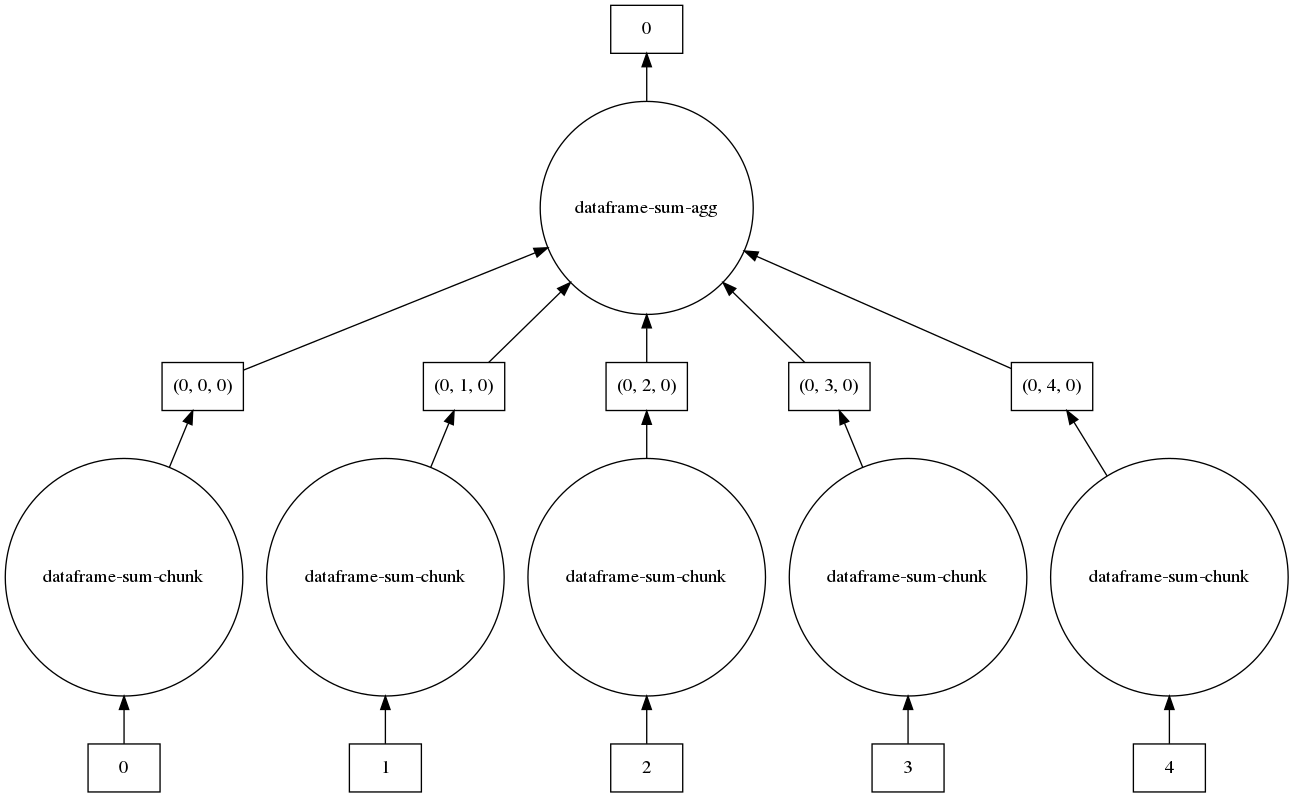

In [27]:
ddf.sum().visualize()

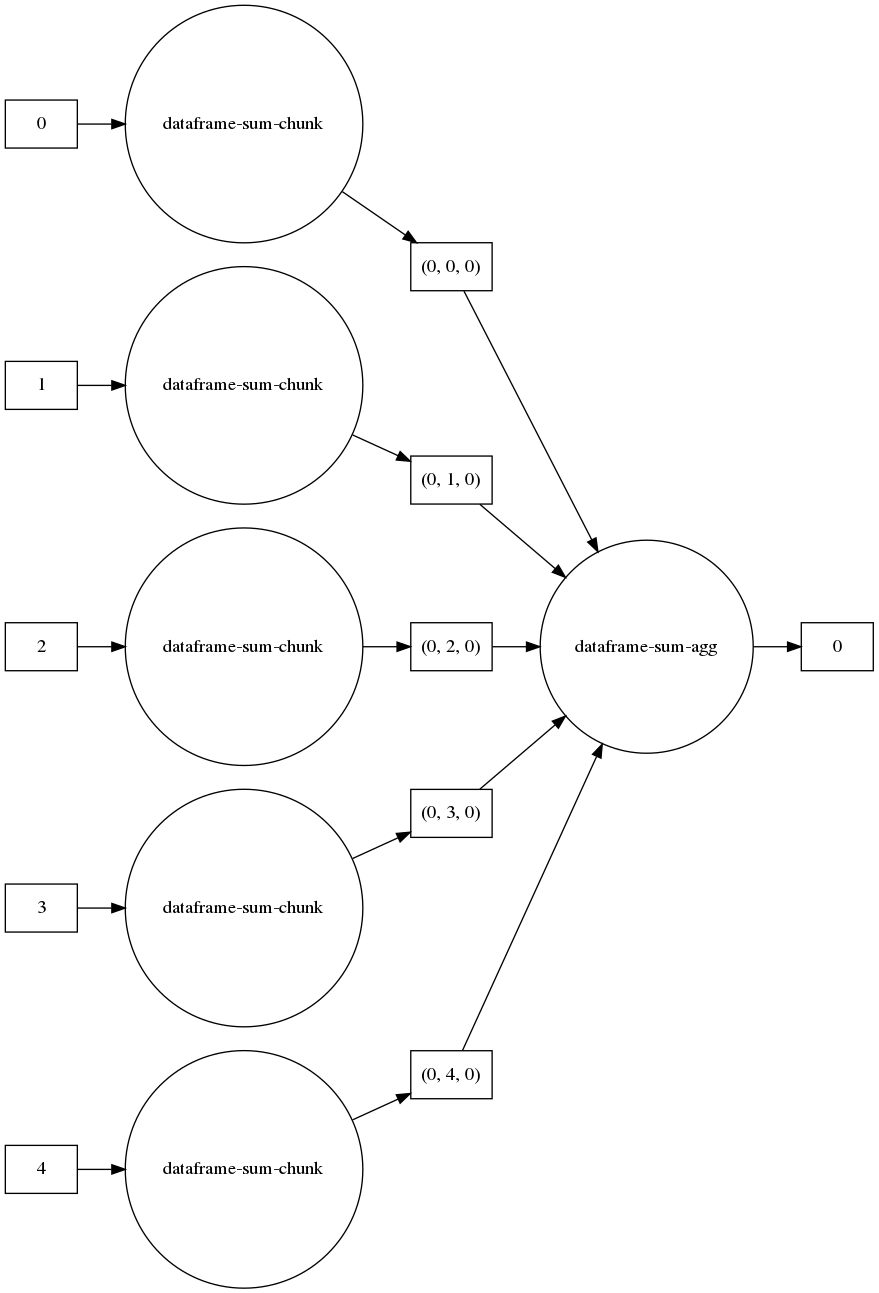

In [28]:
ddf.sum().visualize(rankdir="LR")

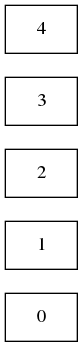

In [29]:
(ddf).visualize(rankdir="LR")

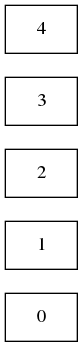

In [30]:
ddf.visualize(rankdir="LR")

In [ ]:
client.close()